In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [35]:
def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  v = np.zeros((n+1,len(y0)))
  y[0] = y0
  v[0] = f(t[0],y[0],gamma)

  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
    v[i+1] = f(t[i+1],y[i+1],gamma)
  return y,t,v

In [36]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.0005 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

In [37]:
k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
np.random.seed(0)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)
A_vals = A(K,L)

def modulo_grid(x, y):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod,y_mod

def streamfunction(t,pos):
  x_mod,y_mod = modulo_grid(*pos)
  psi = np.sum(A_vals * np.cos(K*x_mod + L*y_mod - omega_vals*t + phi))
  return psi

def f(t,pos,gamma):
  #Uncomment to freeze the velocity field at t=snapshot:
  #t = snapshot
  x_mod,y_mod = modulo_grid(*pos)
  dpsi_dx = -np.sum(A_vals*K*np.sin(K*x_mod + L*y_mod - omega_vals*t + phi))
  dpsi_dy = -np.sum(A_vals * L * np.sin(K*x_mod + L*y_mod - omega_vals*t + phi))
  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  return np.array([u,v])

In [47]:
#Code to sample the speed. Should be around 0.0288 in our units.

X, Y = np.linspace(-np.pi,np.pi,200), np.linspace(-np.pi,np.pi,200)
vels = np.empty((len(X),len(Y),2))
gamma = 0
snapshot = 1
for i,x in enumerate(X):
  for j,y in enumerate(Y):
    vels[i,j] = f(snapshot,(x,y),gamma)

speeds = np.linalg.norm(vels, axis=2)
speeds.mean()

0.019302878314652504

In [38]:
#Generate an ensemble of trajectories:

num_points = 100
x_coords = np.random.uniform(-np.pi, np.pi, num_points)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)
initial_conditions = np.column_stack((x_coords, y_coords))

time_span = 365 #number of days
n = 1000 #number of time steps
dt = time_span / n #length of timestep

#Select the value of gamma
gamma = 0

#Store the corresponding trajectories, and velocities along them.
solutions = []
vels = []
for y0 in initial_conditions:
  y,t,v = rk4(f,y0,dt,n,gamma)
  solutions.append(y)
  vels.append(v)



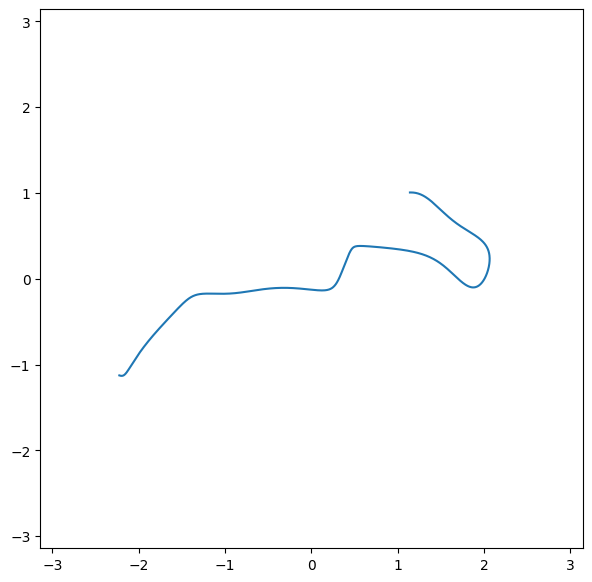

In [50]:
#Visualise a single trajectory
i = 96
sol = solutions[i]
vel = vels[i]

fig,ax = plt.subplots(figsize=(7,7))

ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.plot(sol[:,1],sol[:,0])


In [40]:
#Generate a grid of streamfunction values at time = snapshot
snapshot = 1
X, Y = np.linspace(-np.pi,np.pi,200), np.linspace(-np.pi,np.pi,200)
psi = np.empty((len(X),len(Y)))
for i,x in enumerate(X):
  for j,y in enumerate(Y):
    psi[i,j] = streamfunction(snapshot,(x,y))

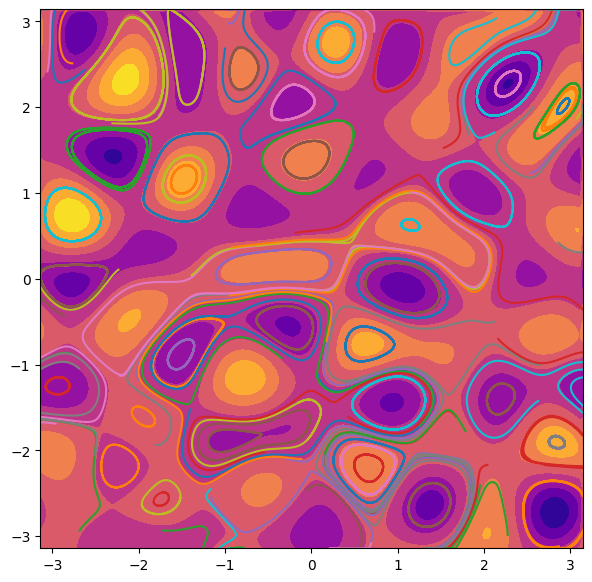

In [41]:
#Snapshot with trajectories overlayed

fig,ax = plt.subplots(figsize=(7,7))
ax.contourf(X,Y,psi)
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)

for sol in solutions:
  ax.plot(sol[:,1],sol[:,0])

plt.save_fig()


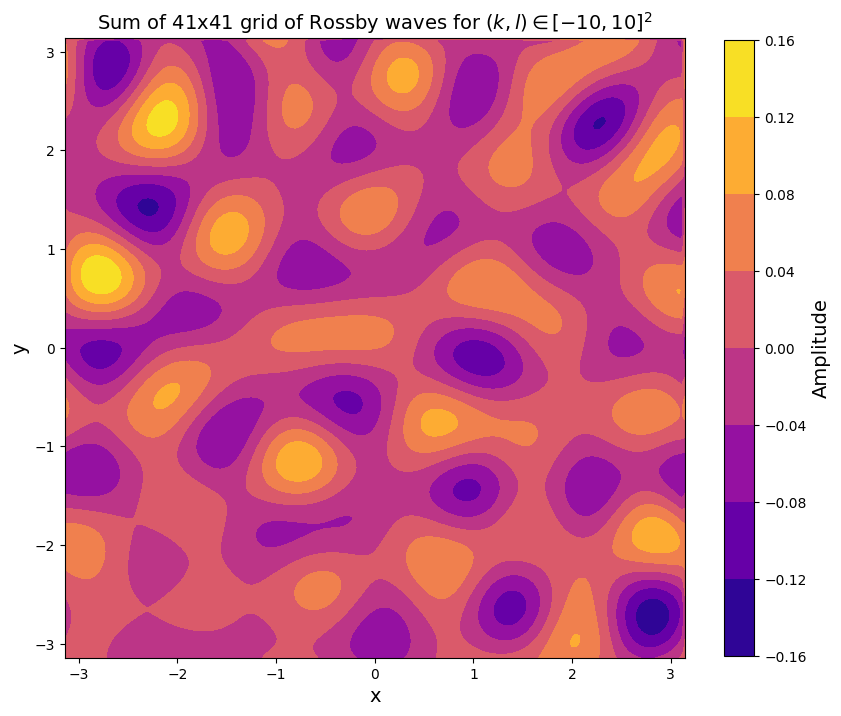

In [ ]:
#Snapshot
s = 14
fig,ax = plt.subplots(figsize=(10,10))
contour = ax.contourf(X,Y,psi,cmap='plasma')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.set_aspect('equal')
ax.set_xlabel('x',fontsize = s)
ax.set_ylabel('y',fontsize = s)
ax.set_title('Sum of 41x41 grid of Rossby waves for $(k,l) \in [-10,10]^2$', fontsize = s)

cbar = fig.colorbar(contour,shrink=0.8)
cbar.set_label('Amplitude',fontsize=s)



plt.savefig('manyrossby.png', dpi=300)